In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M


=== Split 1: Train 40% / Test 60% ===


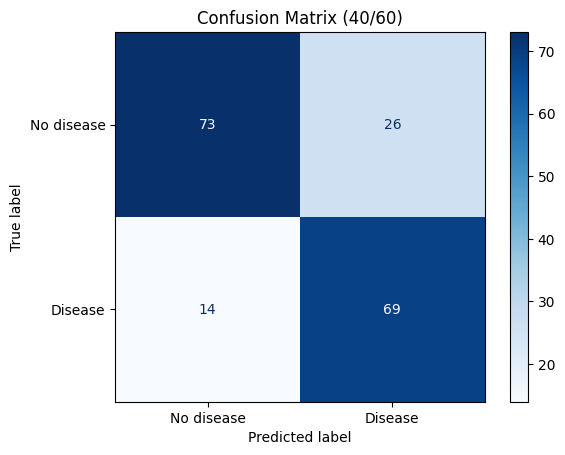

              precision    recall  f1-score   support

  No disease       0.84      0.74      0.78        99
     Disease       0.73      0.83      0.78        83

    accuracy                           0.78       182
   macro avg       0.78      0.78      0.78       182
weighted avg       0.79      0.78      0.78       182


=== Split 2: Train 60% / Test 40% ===


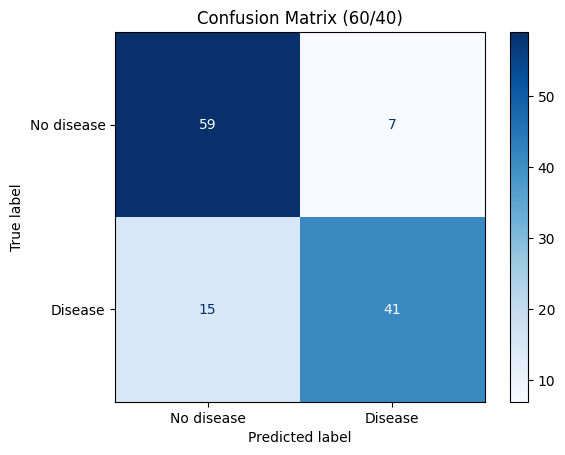

              precision    recall  f1-score   support

  No disease       0.80      0.89      0.84        66
     Disease       0.85      0.73      0.79        56

    accuracy                           0.82       122
   macro avg       0.83      0.81      0.82       122
weighted avg       0.82      0.82      0.82       122


=== Split 3: Train 80% / Test 20% ===


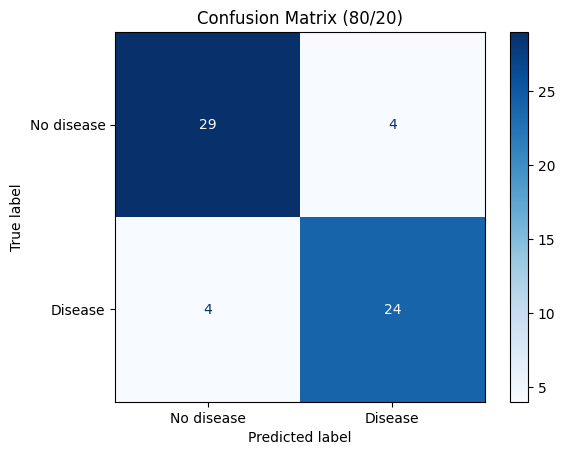

              precision    recall  f1-score   support

  No disease       0.88      0.88      0.88        33
     Disease       0.86      0.86      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


=== Split 4: Train 90% / Test 10% ===


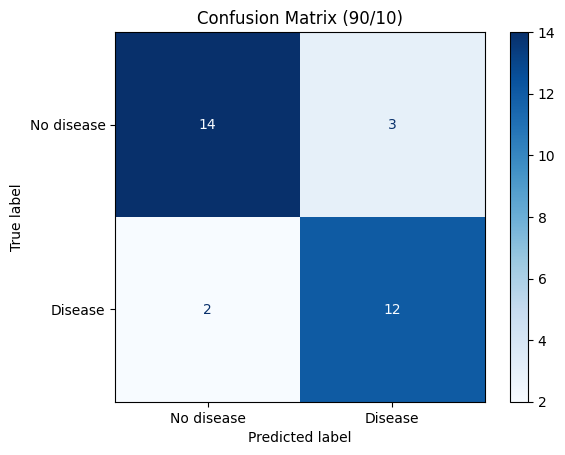

              precision    recall  f1-score   support

  No disease       0.88      0.82      0.85        17
     Disease       0.80      0.86      0.83        14

    accuracy                           0.84        31
   macro avg       0.84      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31



In [ ]:
# Tiền xử lý mới
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import graphviz
import os

# ======= 1. Truyền dataset =======
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets['num']

y = y.apply(lambda x: 0 if x == 0 else 1)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols += X.columns[X.nunique() <= 10].tolist()  
categorical_cols = list(set(categorical_cols))
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# ======= Tiền xử lý =======
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

def build_pipeline(max_depth=None):
    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(max_depth=max_depth, random_state=45))
    ])

split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
max_depth = 3  # Tùy chỉnh

for i, (train_size, test_size) in enumerate(split_ratios):
    print(f"\n=== Split {i+1}: Train {int(train_size*100)}% / Test {int(test_size*100)}% ===")

    valid_idx = y.dropna().index
    X_valid = X.loc[valid_idx]
    y_valid = y.loc[valid_idx]
    
    feature_train, feature_test, label_train, label_test = train_test_split(
        X_valid, y_valid, train_size=train_size, random_state=42, stratify=y_valid
    )

    model = build_pipeline(max_depth=max_depth)
    model.fit(feature_train, label_train)
    label_pred = model.predict(feature_test)

    # ====== Ma trận nhầm lẫn ======
    cm = confusion_matrix(label_test, label_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No disease", "Disease"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix ({int(train_size*100)}/{int(test_size*100)})")
    plt.show()

    # ====== Báo cáo phân loại ======
    print(classification_report(label_test, label_pred, target_names=["No disease", "Disease"]))

    # ====== Vẽ cây ======
    feature_names = numerical_cols + list(
        model.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_cols)
    )

    dot_data = export_graphviz(
        model.named_steps["classifier"],
        out_file=None,
        feature_names=feature_names,
        class_names=["No disease", "Disease"],
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    graph = graphviz.Source(dot_data)
    graph.render(filename=f"heart_tree_split_{int(train_size*100)}", format='png', cleanup=True)
    graph.view()
